Printeo de imagen y los heatmap creados por nuevo dataset (dataset/sample/fewdetv3.py)

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os

import torch
import torch.utils.data
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory
import cv2
import sys
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
sys.argv = ['-f', 'fewdetv3', '--exp_id', 'coco_dlav7','--num_workers', '0','--batch_size','2', '--arch','dlav7_34'] #cmd = 'ctdet --exp_id coco_dla --batch_size 4 --lr 1.25e-4  --gpus 0 --num_workers 0'
opt = opts().parse()
print(opt.task)
print(opt.num_workers)
print(opt.batch_size)

Fix size testing.
training chunk_sizes: [2]
The output will be saved to  C:\Users\avata\FewShot-CenterNet\src\lib\..\..\exp\fewdetv3\coco_dlav7
fewdetv3
0
2


In [3]:
torch.manual_seed(opt.seed)
torch.backends.cudnn.benchmark = not opt.not_cuda_benchmark and not opt.test

In [4]:
opt.reg_loss

'l1'

In [5]:
Dataset = get_dataset(opt.dataset, opt.task)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
logger = Logger(opt)
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.device = torch.device('cuda' if opt.gpus[0] >= 0 else 'cpu')

heads {'ss': 80, 'hm': 1, 'wh': 2, 'reg': 2}


In [6]:
model = create_model(opt.arch, opt.heads, opt.head_conv)
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
start_epoch = 0
if opt.load_model != '':
    model, optimizer, start_epoch = load_model(model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step)

In [7]:
Trainer = train_factory[opt.task]
trainer = Trainer(opt, model, optimizer)
trainer.set_device(opt.gpus, opt.chunk_sizes, opt.device)

In [8]:
train_loader = torch.utils.data.DataLoader(
      Dataset(opt, 'train'), 
      batch_size=opt.batch_size, 
      shuffle=True,
      num_workers=opt.num_workers,
      pin_memory=True,
      drop_last=True
  )

==> initializing coco 2017 train data.
loading annotations into memory...
Done (t=14.24s)
creating index...
index created!
Loaded train 118287 samples


In [23]:
img = next(iter(train_loader))

In [24]:
print(img.keys())
print(img['input'].size())

dict_keys(['input', 'ss', 'hm', 'reg_mask', 'ind', 'wh', 'reg'])
torch.Size([2, 3, 512, 512])


In [25]:
print(img['ss'].size())

torch.Size([2, 128])


In [26]:
img['ss'][0]

tensor([22, 22, 22, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0])

In [27]:
img['hm'].size()

torch.Size([2, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


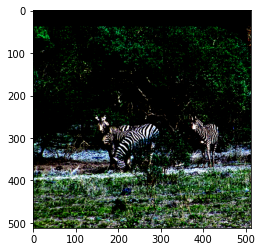

In [28]:
b = 0
img_r = img['input'][b].permute(1,2,0)
img_r = img_r.permute(2,0,1)
img_r = img_r.permute(1,2,0)
img_hm = img['hm'][b]
plt.imshow(img_r)

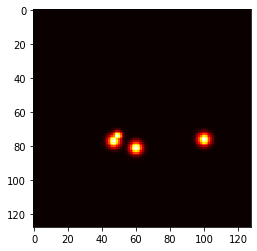

In [29]:
plt.imshow(img_hm, cmap='hot', interpolation='nearest')

In [32]:
torch.max(img_hm)

tensor(1.)

In [16]:
a = torch.empty(2,80,128,129)
print(a.size())
a = a.permute(0,2,3,1)
print(a.size())
a = a.permute(0,3,1,2)
print(a.size())

torch.Size([2, 80, 128, 129])
torch.Size([2, 128, 129, 80])
torch.Size([2, 80, 128, 129])


torch.Size([2, 128, 129, 80])